In [41]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from numpy.linalg import pinv

from tensorly.decomposition import tucker, constrained_parafac

In [2]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [3]:
G, ego_gs, roots = load_network('datasets/blogcatalog.mat')

roots = [int(r) for r in roots]

print(f'Using {len(ego_gs)} egonets')

Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

Using 5196 egonets


In [10]:
# 1: anomalous egonet ==> anomalous root
# 2: anomalous egonet ==> any anomalous node

print('1: anomalous egonet ==> anomalous root')
print('2: anomalous egonet ==> any anomalous node')

anom_def = int(input('Anomalous definition: '))

anom_gs, clean_gs = [], []
labels = []
if anom_def == 1:
    for idx, root_attr in enumerate(tqdm(roots)):
        if root_attr == 1:
            anom_gs.append(ego_gs[idx])
            labels.append(1)
        else:
            clean_gs.append(ego_gs[idx])
            labels.append(0)
elif anom_def == 2:
    for idx, g in enumerate(tqdm(ego_gs)):
        # check if root is anomolous first
        if is_anomolous(g):
            anom_gs.append(g)
            labels.append(1)
        else:
            clean_gs.append(g)
            labels.append(0)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

1: anomalous egonet ==> anomalous root
2: anomalous egonet ==> any anomalous node


  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [6]:
slice_size = int(input("Input a slice size for tensor: "))

In [20]:
cube = torch.empty((1, slice_size, slice_size, slice_size))

# select n random egonets
sampled_gs = np.random.choice(ego_gs, size=slice_size, replace=True)

for i in tqdm(range(len(sampled_gs))):
    slice_gs = nx.to_numpy_array(sampled_gs[i])[:slice_size, :slice_size]
    result = np.zeros((slice_size, slice_size))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

# for i in tqdm(range(len(clean_gs[:slice_size]))):
#     slice_gs = nx.to_numpy_array(clean_gs[i])[:slice_size, :slice_size]
#     result = np.zeros((slice_size, slice_size))
#     result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
#     ten = torch.as_tensor(result)
#     dim = ten.shape[0]
#     cube[0, :dim, :dim, i] = ten

/tmp/ipykernel_4146409/821887668.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sampled_gs = np.random.choice(ego_gs, size=slice_size, replace=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    # add 1s to diagonal
    for idx, row in enumerate(padded):
        row[idx] = 1
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    # add 1s to diagonal
    for idx, row in enumerate(padded):
        row[idx] = 1
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [23]:
_, factors = tucker(cube[0].numpy(), rank=10)

In [24]:
# with open('bc_tkd_r10.sav', 'rb') as f:
#     _, factors = pickle.load(f)
#     f.close()

A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

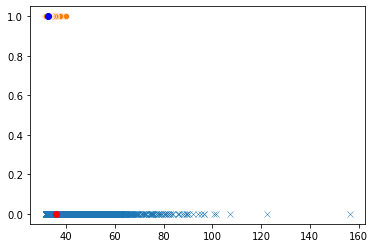

In [25]:
anom_y = np.zeros(len(anom_gs))
clean_y = np.zeros(len(clean_gs))

sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 1, c='blue')

In [26]:
results = np.column_stack((np.array(results_clean + results_anom), np.zeros(len(ego_gs))))

In [27]:
labels = []
labels +=  [0] * len(results_clean) + [1] * len(results_anom)

# Kitchen Sink
https://pyod.readthedocs.io/en/latest/index.html

In [28]:
from pyod.models.suod import SUOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.anogan import AnoGAN
from pyod.models.cblof import CBLOF
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.inne import INNE
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.lmdd import LMDD
from pyod.models.ocsvm import OCSVM
from pyod.models.mad import MAD
from pyod.models.pca import PCA
from pyod.models.so_gaal import SO_GAAL
from pyod.models.xgbod import XGBOD

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import torch
from torch.nn import MSELoss

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(results, labels, test_size=0.33, random_state=42)

In [98]:
# # DeepSVDD(), DeepSVDD(use_ae=True), AnoGAN(), AutoEncoder()
# detector_list = [
#     LOF(n_neighbors=20), 
#     IForest(n_estimators=100), 
#     # GMM(), 
#     # KNN(), 
#     # HBOS(), 
#     # INNE(), 
#     # COPOD(), 
#     # LOF(),
# ]

# # decide the number of parallel process, and the combination method
# # then clf can be used as any outlier detection model
# clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
#            verbose=False)

# clf.fit(X_train, y_train)

In [99]:
# # get the prediction labels and outlier scores of the training data
# y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
# y_train_scores = clf.decision_scores_  # raw outlier scores

# # get the prediction on the test data
# y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
# y_test_scores = clf.decision_function(X_test)  # outlier scores

# # evaluate and print the results
# print("\nOn Training Data:")
# evaluate_print('SUOD', y_train, y_train_scores)
# print("\nOn Test Data:")
# evaluate_print('SUOD', y_test, y_test_scores)

# # visualize the results
# visualize('SUOD', X_train, y_train, X_test, y_test, y_train_pred,
#           y_test_pred, show_figure=True, save_figure=False)

# XGBOD

[14:27:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:27:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

On Training Data:
SUOD ROC:0.872, precision @ rank n:0.9436

On Test Data:
SUOD ROC:0.8272, precision @ rank n:0.9186


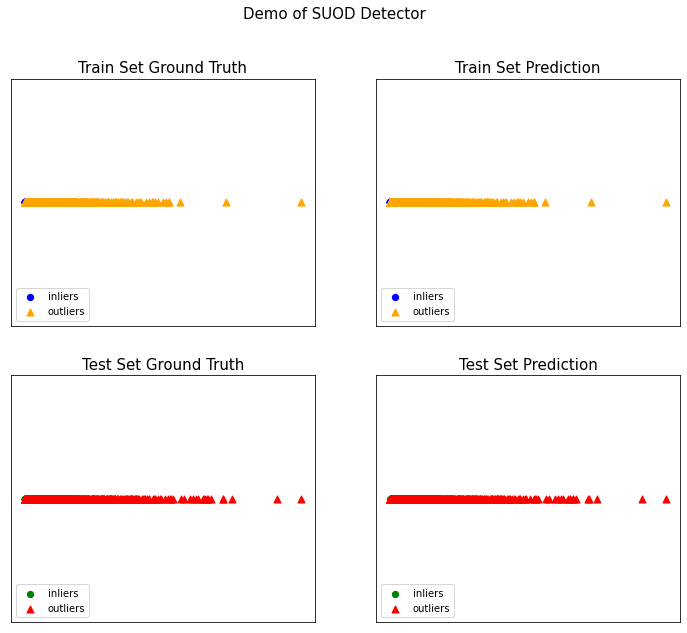

In [34]:
clf = XGBOD(estimator_list=[IForest()])
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('SUOD', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('SUOD', y_test, y_test_scores)

# visualize the results
visualize('SUOD', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [35]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.01      0.01       175
           1       0.90      1.00      0.95      1540

    accuracy                           0.90      1715
   macro avg       0.70      0.50      0.48      1715
weighted avg       0.86      0.90      0.85      1715



In [38]:
# Only report results for the class specified by pos_label (1)

print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_scores))

F1: 0.9462035044574238
ROC-AUC: 0.8271558441558443


Text(0, 0.5, 'True Positive Rate')

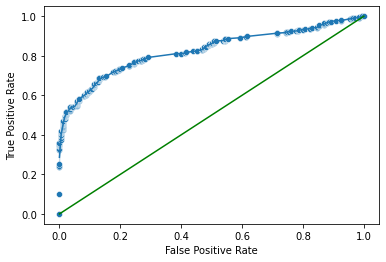

In [47]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)

sns.scatterplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")